In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Dataframe transformation between mean or median readout of each PCONS in STARR-seq using these functions
def graph_transform_mean(df):
    df = df.groupby(['pCONS','biorep','sample']).mean()[['normalized_freq']].reset_index()
    df['log_freq'] = df['normalized_freq'].apply(np.log2)
    return df

def graph_transform_median(df):
    df = df.groupby(['pCONS','biorep','sample']).median()[['normalized_freq']].reset_index()
    df['log_freq'] = df['normalized_freq'].apply(np.log2)

In [2]:
starr = pd.read_csv('minPRA/tob_let_starr.csv')

In [3]:
plant_pivot = starr.pivot(index=["pCONS", "biorep","tech","fluor", 'ensemb_lab'],
                       columns='plant', values='log_freq').reset_index()

In [4]:
order = []
controls = list(reversed(plant_pivot.pCONS.unique()[0:2]))
highs = plant_pivot.pCONS.unique()[2:7]
lows = plant_pivot.pCONS.unique()[7:12]
meds = plant_pivot.pCONS.unique()[12:]

for sublist in [lows, meds, highs, controls]:
    order.extend(sublist)
order = list(reversed(order))

Text(0.1, 0.7, '$\\rho =$0.866\n$P =$0.000')

Text(0.1, 0.7, '$\\rho =$0.744\n$P =$0.000')

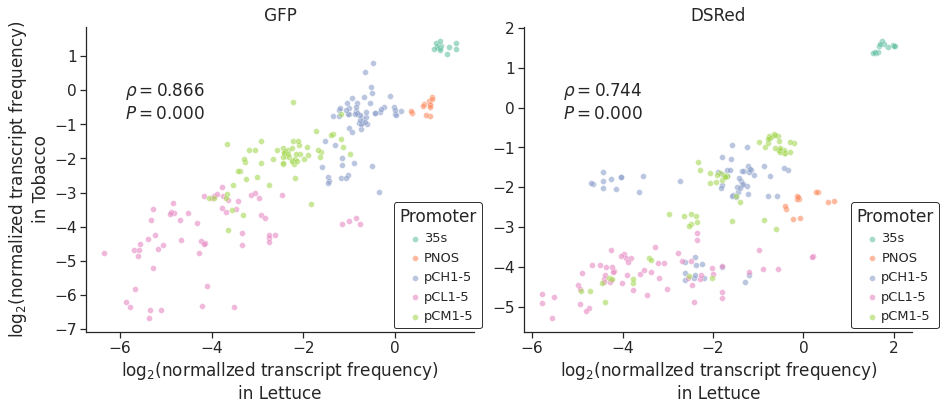

In [5]:
d_pearson = plant_pivot.groupby('fluor').apply(lambda x: stats.pearsonr(x.Lettuce, x.Tobacco)).to_dict()
d_keys = ['GFP', 'DSRed'] 
sns.set_context('paper')
sns.set(font_scale=1.4)
sns.set_style('ticks')
sns.set_palette('Set2')

g = sns.FacetGrid(data=plant_pivot, 
                  col="fluor",
                  sharex=False, sharey=False, 
                  hue="ensemb_lab", 
                  col_order=d_keys,
                  height=6, aspect=1)
g.map(sns.scatterplot, "Lettuce", "Tobacco", s=35, alpha=0.6)
g.set_titles(col_template="{col_name}")
g.set_ylabels('log$_2$(normalized transcript frequency)\nin Tobacco')
g.set_xlabels('log$_2$(normallzed transcript frequency)\nin Lettuce')
g.add_legend(title="Promoter", **dict(bbox_to_anchor=(.48, .36), 
                                      columnspacing=0, frameon=True, edgecolor='black', handletextpad=-0.3, fontsize=13))
g.add_legend(title="Promoter", **dict(bbox_to_anchor=(.92, .36), 
                                      columnspacing=0, frameon=True, edgecolor='black', handletextpad=-0.3, fontsize=13))

for idx, ax in enumerate(g.axes.ravel()):
    ax.annotate(r'$\rho =$' f'{d_pearson[d_keys[idx]][0]:.3f}'
                +'\n'
                + r'$P =$' f'{d_pearson[d_keys[idx]][1]:.3f}', 
                xy=(0.1, .7), xycoords='axes fraction')
g.tight_layout()
# plt.subplots_adjust(hspace=.5, wspace=1.2)
g.savefig(fname="figs/fig5B.pdf", bbox_inches="tight")

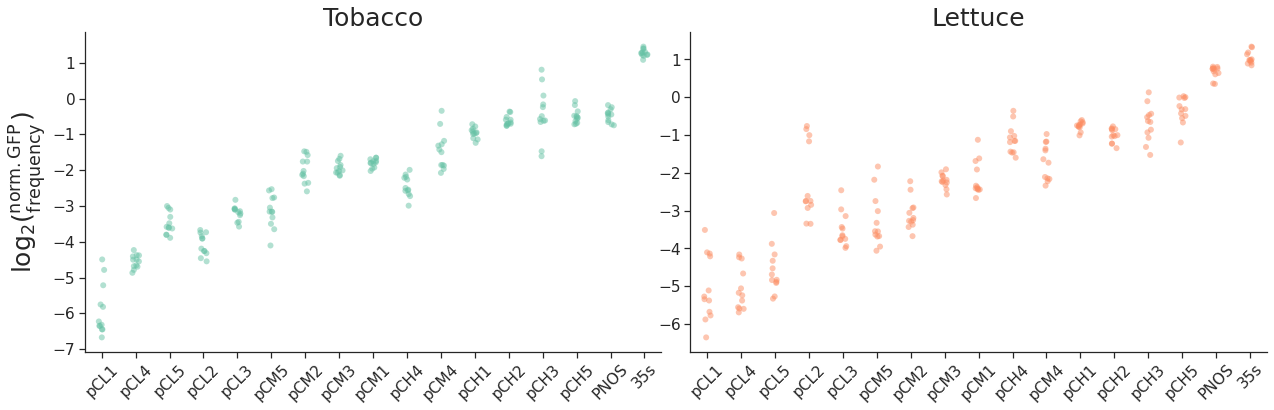

In [6]:
sns.set_context('paper')
sns.set(font_scale=1.4)
sns.set_style('ticks')
order = graph_transform_mean(starr.query('fluor == "GFP"')).groupby('pCONS').median()['log_freq'].sort_values().index
g = sns.FacetGrid(data=starr.query('fluor == "GFP"'), 
                  col="plant",
                  sharex=True, sharey=False, 
                  hue="plant", height=6, aspect=1.5, palette=sns.color_palette('Set2'))
g.map(sns.stripplot, "pCONS", "log_freq", order=order, size=6, alpha=0.5)
g.set_titles(col_template="{col_name}", size=25)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_ylabels(r'$\rm{log}_2(\genfrac{}{}{0}{}{\rm{norm. GFP}}{\rm{frequency}})$', size=25)
g.set_xlabels('')
g.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.05)
g.savefig(fname="figs/Fig5C.pdf", bbox_inches="tight")

In [7]:
tech_pivot = starr.pivot(index=["pCONS", "biorep","plant","fluor", 'ensemb_lab'],
                         columns='tech', values='log_freq').reset_index()

Text(0.75, 0.1, '$\\rho =$0.972\n$P =$0.000')

Text(0.75, 0.1, '$\\rho =$0.987\n$P =$0.000')

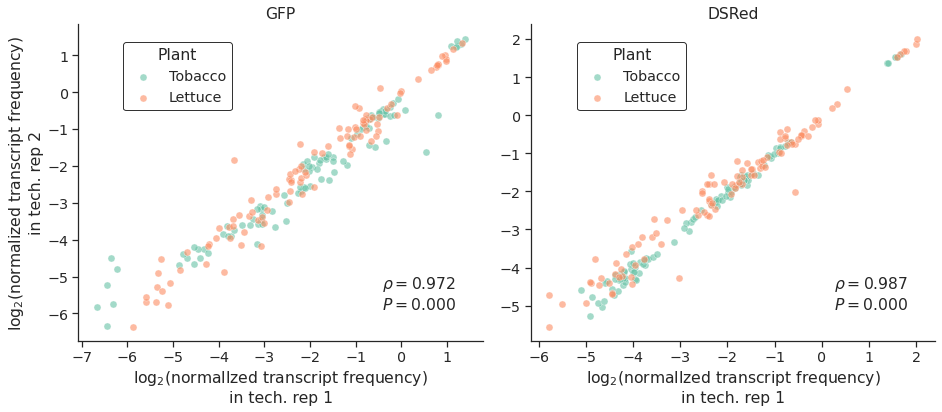

In [8]:
d_pearson = tech_pivot.groupby('fluor').apply(lambda x: stats.pearsonr(x.Tech1, x.Tech2)).to_dict()
d_keys = ['GFP', 'DSRed'] 
sns.set_context('talk')
sns.set(font_scale=1.3)
sns.set_style('ticks')
sns.set_palette('Set2')
g = sns.FacetGrid(data=tech_pivot, 
                  col="fluor",
                  sharex=False, sharey=False, 
                  hue='plant', height=6, aspect=1, col_order=d_keys, hue_order=['Tobacco', 'Lettuce'])
g.map(sns.scatterplot, "Tech1", "Tech2", s=50, alpha=0.6)
g.set_titles(col_template="{col_name}")
g.set_ylabels('log$_2$(normalized transcript frequency)\nin tech. rep 2')
g.set_xlabels('log$_2$(normallzed transcript frequency)\nin tech. rep 1')
g.add_legend(title="Plant", **dict(bbox_to_anchor=(0.23, .8), 
                                      columnspacing=0, frameon=True, edgecolor='black'))

g.add_legend(title="Plant", **dict(bbox_to_anchor=(0.65, .8), 
                                      columnspacing=0, frameon=True, edgecolor='black'))
for idx, ax in enumerate(g.axes.ravel()):
    ax.annotate(r'$\rho =$' f'{d_pearson[d_keys[idx]][0]:.3f}'+'\n'+ r'$P =$' f'{d_pearson[d_keys[idx]][1]:.3f}', 
                xy=(0.75, 0.1), xycoords='axes fraction')
g.tight_layout()
g.savefig(fname="figs/Fig5D.pdf", bbox_inches="tight")